In [1]:
import snap
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pylab

from numpy.linalg import norm
%matplotlib inline

In [2]:
# import data as pandas dataframe
data = pd.read_csv('out.wikiconflict', header = None, skiprows = 2, sep = " ")
data.columns = ['src', 'dst', 'wt', 'ts']
maxTS = max(data['ts'])
minTS = min(data['ts'])
data = data.sort('ts', ascending=[True])
#print data.head(5)

In [3]:
# Check for edges if SrcNId < DestNId
XYZ = data[data['src'] > data['dst']]
print XYZ.shape
#print XYZ.head(2)

(0, 4)


In [4]:
# sample at equal interval timestamps to
# track the evolution of the network
intervals = 10
length = (maxTS - minTS) / intervals
times = np.arange(minTS, maxTS+1, length)
times[intervals] = maxTS
times = list(times)
times.pop(0)


998892106

/Library/Python/2.7/site-packages/pandas/util/decorators.py:81: FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead
  warnings.warn(msg, FutureWarning)


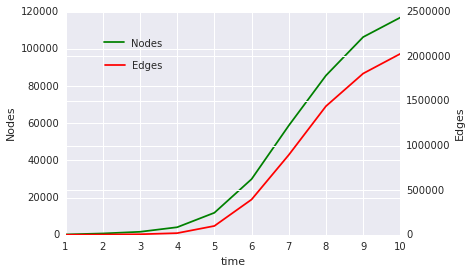

In [5]:
# plot time evolution of nodes in graph
# Also store time series of graphs in separate files.
# Makes easier to read later in snap.
# In the following analysis we drop duplicates meaning if there has been an exchange of 
# conflicts between a pair of nodes multiple time then we only select the last time of the 
# conflict and the final weight. This is just for initial analysis purpose.

nodes = []
edges = []
i=1
for t in times:
    df = data[data['ts'] < t]
    #X = df.drop_duplicates(cols=['src', 'dst'], take_last=True)
    df1 = df.drop_duplicates(cols=['src', 'dst'], take_last=True)
    df1.columns = ['src', 'dst', 'wtf', 'tsf']
    
    df2 = df.drop_duplicates(cols=['src', 'dst'])
    df2.columns = ['src', 'dst', 'wt0', 'ts0']
    
    gr1 = df.groupby(['src', 'dst']).count()
    gr1.reset_index(inplace=True)
    gr1 = gr1[['src', 'dst', 'wt']]
    gr1.columns = ['src', 'dst', 'count']
    
    M = df2.merge(df1, on = ['src', 'dst'], how = 'inner')
    M = M.merge(gr1, on = ['src', 'dst'], how = 'inner')
    M = M.sort('tsf', ascending=[True])
    
    file = 'G_'+str(i)+'.txt'
    M.to_csv(file, sep=" ", header = False, index = False)
    #X.to_csv('X.csv', sep=",", header = False, index = False)
    
    n1 = M['src'].unique()
    n2 = M['dst'].unique()
    n = set(list(n1)+list(n2))
    nodes.append(len(n))
    edges.append(M.shape[0])
    i += 1
   
fig, ax1 = plt.subplots()
ax1.plot(range(1, len(times)+1), nodes, 'g', label='Nodes')
ax1.set_ylabel('Nodes')
ax1.set_xlabel('time')
plt.legend(bbox_to_anchor=(0.3, 0.9), loc=1, borderaxespad=0.)
ax2 = ax1.twinx()
ax2.plot(range(1, len(times)+1), edges, 'r', label='Edges')
ax2.set_ylabel('Edges')
plt.legend(bbox_to_anchor=(0.3, 0.8), loc=1, borderaxespad=0.)
pp = PdfPages('wikiNodesEdgesTS.pdf')
pp.savefig()
pp.close()


In [41]:
# Following function would return diameter for unweighted and undirected graph
# meaning it treats all edges have weight = 1.
def GetDiameter(UGraph):
    wcc = snap.GetMxWcc(UGraph)
    u = wcc.GetRndNId()
    d_uv = 0
    for h in range(1, 1000):
        NodeVec = snap.TIntV()
        n = snap.GetNodesAtHop(wcc, u, h, NodeVec, False)
        if n == 0:
            break
        d_uv += 1

    NodeVec = snap.TIntV()
    n = snap.GetNodesAtHop(wcc, u, d_uv, NodeVec, False)
    v = NodeVec[0]

    d_vw = 0
    for h in range(1, 1000):
        NodeVec = snap.TIntV()
        n = snap.GetNodesAtHop(wcc, v, d_vw, NodeVec, False)
        if n == 0:
            break
        d_vw += 1

    diam = d_vw

    return diam

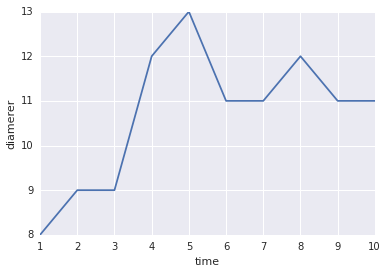

In [34]:
# Plot time evolution of diameter of the graph.

diameters = []
for i in range(1, (len(times)+1)):
    file = 'G_'+ str(i) + '.txt'
    UGraph = snap.LoadEdgeList(snap.PUNGraph, file, 0, 1)
    diam = GetDiameter(UGraph)
    diameters.append(diam)
       

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
plt.plot(range(1, len(times)+1), diameters)
plt.xlabel('time')
plt.ylabel('diamerer')

pp = PdfPages('wikiDiameterTS.pdf')
pp.savefig()
pp.close()

       

In [46]:
# Calculates the ratio of different types of triads in a network.
# Network should have edge attributes representing signs.
def GetFractionOfTriadTypes(Net, attr1, attr2):
    tDict = {-3:'t0', -1:'t1', 1:'t2', 3:'t3'}
    countDict = {'t0':0, 't1':0, 't2':0, 't3':0}
    X, Y, Z = [], [], []

    for NI in Net.Nodes():
        NId = NI.GetId()
        NodeVec = snap.TIntV()
        Nbrs = snap.GetNodesAtHop(Net, NId, 1, NodeVec, False)
        SubGraph = snap.GetSubGraph(Net, NodeVec)
        for EI in SubGraph.Edges():
            nbr1 = EI.GetSrcNId()
            nbr2 = EI.GetDstNId()
            if nbr1 > NId and nbr2 > NId:
                EI1 = Net.GetEI(NId, nbr1)
                EI2 = Net.GetEI(NId, nbr2)
                EI3 = Net.GetEI(nbr1, nbr2)
                s1 = Net.GetIntAttrDatE(EI1, attr1)
                s2 = Net.GetIntAttrDatE(EI2, attr1)
                s3 = Net.GetIntAttrDatE(EI3, attr1)
                key = s1+s2+s3
                if key in tDict:
                    countDict[tDict[key]] = countDict[tDict[key]] + 1
                
                w1 = Net.GetFltAttrDatE(EI1, attr2)
                w2 = Net.GetFltAttrDatE(EI2, attr2)
                w3 = Net.GetFltAttrDatE(EI3, attr2)
                x = w1+w2+w3
                y = w1*w2*w3
                z = w1*w2 + w2*w3 + w3*w1
                X.append(x)
                Y.append(y)
                Z.append(z)
        
    totalTriads = countDict['t0'] + countDict['t1'] + countDict['t2'] + countDict['t3']
    t0 = countDict['t0'], float(countDict['t0']) / float(totalTriads)
    t1 = countDict['t1'], float(countDict['t1']) / float(totalTriads)
    t2 = countDict['t2'], float(countDict['t2']) / float(totalTriads)
    t3 = countDict['t3'], float(countDict['t3']) / float(totalTriads)
    
    return [t0, t1, t2, t3, X, Y, Z]
    

In [47]:
# len(times) is the number of sampled graphs we stored
time, t0, t1, t2, t3 = [], [], [], [], []
muX, muY, muZ = [], [], []
covar = []
#for i in range(1, (len(times)+1)):
for i in range(1, 8):  # properties converge around this time.
    Net = snap.LoadEdgeList(snap.PNEANet, 'G_'+str(i)+'.txt', 0, 1)
    attr1 = 'sign'
    attr2 = 'wt0'
    attr3 = 'wtf'
    attr4 = 'ts0'
    attr5 = 'tsf'
    attr6 = 'multiplicity'
    Net.AddIntAttrE(attr1)
    Net.AddFltAttrE(attr2)
    Net.AddFltAttrE(attr3)
    Net.AddIntAttrE(attr4)
    Net.AddIntAttrE(attr5)
    Net.AddIntAttrE(attr6)
    NumPosEdges = 0
    NumNegEdges = 0
    file = open('G_'+str(i)+'.txt', "r")
    print 'G_'+str(i)+'.txt'
    with file:
        for line in file:
            ss = line.split(" ")
            SrcNId = int(ss[0])
            DstNId = int(ss[1])
            wt0 = float(ss[2])
            ts0 = int(ss[3])
            wtf = float(ss[4])
            tsf = int(ss[5])
            count = int(re.sub('\\n$', '', ss[6]))
            EdgeI = Net.GetEI(SrcNId, DstNId)
            Net.AddIntAttrDatE(EdgeI, int(np.sign(wtf)), attr1)
            Net.AddFltAttrDatE(EdgeI, wt0, attr2)
            Net.AddFltAttrDatE(EdgeI, wtf, attr3)
            Net.AddIntAttrDatE(EdgeI, ts0, attr4)
            Net.AddIntAttrDatE(EdgeI, tsf, attr5)
            Net.AddIntAttrDatE(EdgeI, count, attr6)

            if (np.sign(wt0)) > 0:
                NumPosEdges += 1
            if (np.sign(wt0)) < 0:
                NumNegEdges += 1
    file.close()
    #print 'Finished reading file'
    #print
    triads = GetFractionOfTriadTypes(Net, attr1, attr3)
    time.append(i)
    t0.append(triads[0])
    t1.append(triads[1])
    t2.append(triads[2])
    t3.append(triads[3])
    
    X = triads[4]
    Y = triads[5]
    Z = triads[6]
    
    muX.append(np.mean(np.array(X)))
    muY.append(np.mean(np.array(Y)))
    muZ.append(np.mean(np.array(Z)))
    
    # Get covariance
    cols = len(X)
    rows = 3
    Mat = np.zeros((3, cols))
    Mat[0, :] = X
    Mat[1, :] = Y
    Mat[2, :] = Z
    result = np.cov(Mat)
    covar.append(result)
    #print ' mat shape ', result.shape

G_1.txt
G_2.txt
G_3.txt
G_4.txt
G_5.txt
G_6.txt
G_7.txt


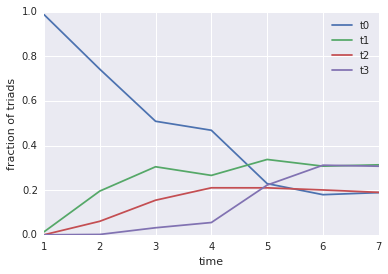

In [21]:
x0, x1, x2, x3 = [], [], [], []
for i in range(len(t0)):
    x0.append(t0[i][1])
for i in range(len(t1)):
    x1.append(t1[i][1])
for i in range(len(t2)):
    x2.append(t2[i][1])
for i in range(len(t3)):
    x3.append(t3[i][1])    

plt.plot(time, x0, label='t0')
plt.plot(time, x1, label='t1')
plt.plot(time, x2, label='t2')
plt.plot(time, x3, label='t3')
plt.xlabel('time')
plt.ylabel('fraction of triads')
pylab.legend(loc='upper right')

pp = PdfPages('wikiTriadsTS.pdf')
pp.savefig()
pp.close()

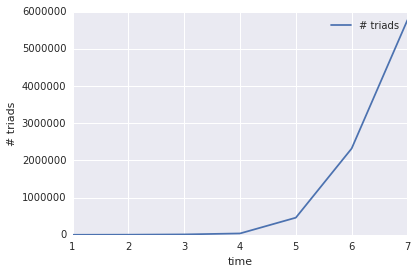

In [48]:
# plot total number of triads
totaltriads = []
for i in range(len(t0)):
    totaltriads.append(t0[i][0] + t1[i][0] + t2[i][0] + t3[i][0])

plt.plot(time, (totaltriads), label='# triads')
plt.xlabel('time')
plt.ylabel('# triads')
pylab.legend(loc='upper right')
    

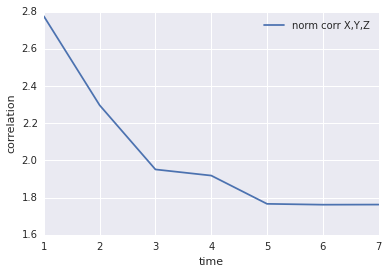

In [49]:
# Plot the ts of norm of correlation of X, Y, Z
# Get the correlation from covariance. Use corrcoef function instead of covar before to get
# correlation directly.
normcovar = []
for x in covar:
    y = x.copy()
    for i in range(3):
        y[i,:] = y[i,:] / np.sqrt(x[i,i])
        y[:,i] = y[:,i] / np.sqrt(x[i,i])
    normsigma = norm(y)
    normcovar.append(normsigma)

plt.plot(time, normcovar, label='norm corr X,Y,Z')
pylab.legend(loc='upper right')
plt.xlabel('time')
plt.ylabel('correlation')
pp = PdfPages('wikiTriadsCorrelation.pdf')
pp.savefig()
pp.close()



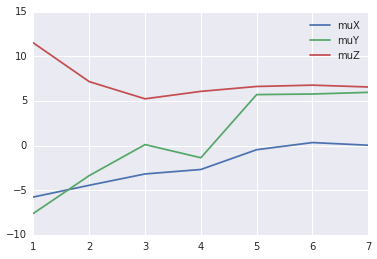

In [50]:
# plot muX, muY, muZ
plt.plot(time, muX, label='muX')
plt.plot(time, muY, label='muY')
plt.plot(time, muZ, label='muZ')
pylab.legend(loc='upper right')
#pp = PdfPages('wikiTriadsPropertyMeans.pdf')
#pp.savefig()
#pp.close()

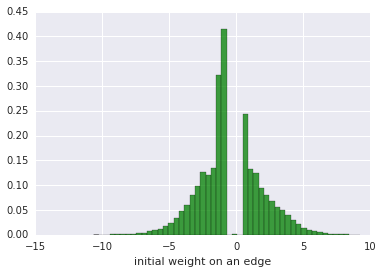

In [16]:
# plot first edge and last edge wts distribution of multiplicity of edges
G = pd.read_csv('G_6.txt', sep = " ", header = None)
G.columns = ['src', 'dst', 'wt0', 'ts0', 'wtf', 'tsf', 'count']
wt0 = G['wt0']
wtf = G['wtf']
#sns_plot = sns.distplot(wtf)
#sns_plot = sns.distplot(wtf-w0)
#sns_plot = sns.distplot(wt0)
#sns_plot.savefig("t7weights.pdf")
n, bins, patches = plt.hist(wt0, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('initial weight on an edge')
pp = PdfPages('wikiWT0SignDistributionG_6.pdf')
pp.savefig()
pp.close()


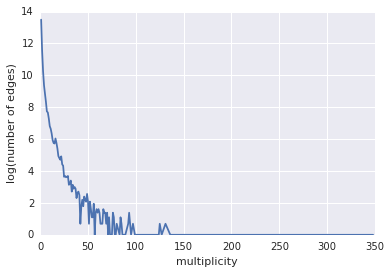

In [45]:
# plot log(multiplicity) of edges
G = pd.read_csv('G_7.txt', sep = " ", header = None)
G.columns = ['src', 'dst', 'wt0', 'ts0', 'wtf', 'tsf', 'count']

#multiplicity = G['count']
counts = np.unique(G['count'])
multiplicity = []
for x in counts:
    n = G[G['count'] == x].shape[0]
    multiplicity.append(n)
#print multiplicity

plt.plot(counts, np.log(multiplicity))
plt.xlabel('multiplicity')
plt.ylabel('log(number of edges)')
#n, bins, patches = plt.hist(multiplicity, 50, normed=1, facecolor='green', alpha=0.75)
#plt.xlabel('log(multiplicity)')

pp = PdfPages('wikiEdgeMultiplicityG_7.pdf')
pp.savefig()
pp.close()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


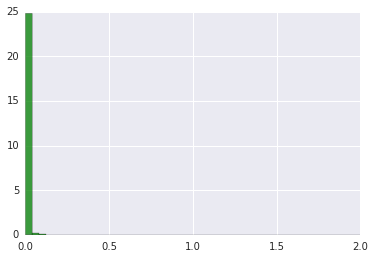

In [35]:
# plot average time between first and last edits between same users
# assign avg time to be zero if only one edit is there.
G = pd.read_csv('G_6.txt', sep = " ", header = None)
G.columns = ['src', 'dst', 'wt0', 'ts0', 'wtf', 'tsf', 'count']
G['avgtime'] = 0.0
G['deltaT'] = G['tsf'] - G['ts0']
zerodT = G[G['deltaT'] == 0]
nonzerodT = G[G['deltaT'] > 0]

nonzerodT['avgtime'] = 1.0*nonzerodT['count'] / nonzerodT['deltaT']
G = zerodT.append(nonzerodT)
    
#plt.xlabel('avgtime')
#pp = PdfPages('wikiEdgeMultiplicityG_6.pdf')
#pp.savefig()
#pp.close()

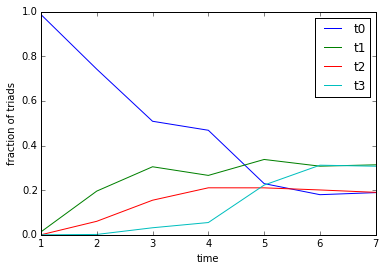

In [47]:
y0, y1, y2, y3 = [], [], [], []
for i in range(len(t0)):
    y0.append(t0[i][1])
for i in range(len(t1)):
    y1.append(t1[i][1])
for i in range(len(t2)):
    y2.append(t2[i][1])
for i in range(len(t3)):
    y3.append(t3[i][1])    

plt.plot(time, y0, label='t0')
plt.plot(time, y1, label='t1')
plt.plot(time, y2, label='t2')
plt.plot(time, y3, label='t3')
plt.xlabel('time')
plt.ylabel('fraction of triads')
pylab.legend(loc='upper right')


In [13]:
i = 1
file = open('G_'+str(i)+'.txt', "r")
print 'G_'+str(i)+'.txt'
with file:
    for line in file:
        ss = line.split(" ")
        print ss
        SrcNId = int(ss[0])
        DstNId = int(ss[1])
        wt0 = float(ss[2])
        ts0 = int(ss[3])
        wtf = float(ss[4])
        tsf = int(ss[5])
        count = int(re.sub('\\n$', '', ss[6]))
        print SrcNId, DstNId, wt0, ts0, wtf, tsf, count
        #timestamp = int(ss[3])
        break
        

G_1.txt
['22063', '32088', '-3.0910424533583165', '998892106', '-3.0910424533583165', '998892106', '1\n']
22063 32088 -3.09104245336 998892106 -3.09104245336 998892106 1
